# Network utility functions

In [1]:
%load_ext autoreload
%autoreload 2

import os
import shutil
from src.spiking_network.network.neuvisys import SpikingNetwork, clean_network
from src.spiking_network.network.network_params import (
    inhibition_learning_params,
)
from src.events.tools.read_write.aedat_tools import (
    load_aedat4,
)
from src.events.tools.read_write.events_tools import (
    write_npz,
    npaedat_to_np,
    ros_to_npy,
)
from src.events.tools.modification.event_modification import (
    show_event_images,
    rectify_events,
    remove_events,
)
from src.events.tools.generation.stimuli_gen import (
    moving_bars,
    moving_lines,
    disparity_bars
)
from src.events.tools.generation.pix2nvs import Pix2Eve
from src.frames.frame_analysis import (
    load_frames,
    rectify_frames,
    write_frames,
    stereo_matching,
)
from src.spiking_network.planning.network_planner import (
    create_networks,
    random_params,
    launch_neuvisys_multi_pass,
    change_param,
    divide_visual_field,
)

os.chdir("/home/thomas/neuvisys-analysis/src")
home = "/home/thomas/"

network_path = home + "neuvisys-dv/configuration/network_ref_vh/"

## CAUTION: Delete Weights

In [ ]:
clean_network(network_path, [0, 1])

## Network creation and launch

In [5]:
# params = {"simple_cell_config" : {"ETA_LTP": [0.0077, 0.0077]}, "complex_cell_config" : {"ETA_LTP": [0.0077, 0.0077]}}
# create_networks(home + "neuvisys-dv/cmake-build-release", home + "Bureau", 2, {})
random_params("/home/thomas/neuvisys-dv/cmake-build-release", "/home/thomas/Desktop/Experiment", 1)

In [ ]:
# Launch training of multiple networks

n_networks = 100
exec_path = home + "neuvisys-dv/build/neuvisys-exe"
networks_path = home + "Desktop/test/"
event_path = home + "Desktop/shapes.npz"

params = {"simple_cell_config": {"TARGET_SPIKE_RATE": [0.1, 0.2, 0.3]}}

create_networks(exec_path, networks_path, n_networks, params)
nb_iterations = 5

df = []

for i in range(0, n_networks):
    launch_neuvisys_multi_pass(
        exec_path, networks_path + "network_" + str(i) + "/configs/network_config.json", event_path, nb_iterations,
    )

    spinet = SpikingNetwork(networks_path + "network_" + str(i) + "/")
    # display_network([spinet], 0)
    # update_dataframe(df, spinet)

# df = pd.DataFrame(df)
# df.to_csv(home + "Desktop/test/df")

#### Inhibition weight learning

In [12]:
exec_path = home + "neuvisys-dv/cmake-build-release/neuvisys-exe"
networks_path = home + "Desktop/Experiment/"
h_events = home + "Videos/lines/hlines.npz"
v_events = home + "Videos/lines/vlines.npz"
hv_events = home + "Videos/lines/vhlines.npz"

events_disp = home + "Videos/disparity/disparity_lines.npz"
events0 = home + "Videos/disparity/0_lines.npz"
events5 = home + "Videos/disparity/5_lines.npz"

disparities = home + "Videos/disparity/disparities.npz"

params = inhibition_learning_params({"network_config": {"nbCameras": 2}})
create_networks(exec_path, networks_path, 1, params)

In [13]:
## learning the base network
path = networks_path + "network_0/"
launch_neuvisys_multi_pass(exec_path, path + "configs/network_config.json", disparities, 3)

change_param(networks_path + "network_0/configs/simple_cell_config.json", "STDP_LEARNING", "none")
change_param(networks_path + "network_0/configs/complex_cell_config.json", "STDP_LEARNING", "none")
shutil.copytree(path, networks_path + "network_control")
shutil.copytree(path, networks_path + "network_inhibition")

Layer 0: new weights generated
Layer 1: new weights generated
Unpacking events...
23%
47%
71%
95%
Saving Network...
Finished.


'/home/thomas/Desktop/Experiment/network_inhibition'

In [11]:
## control test
launch_neuvisys_multi_pass(exec_path, networks_path + "network_control/configs/network_config.json", events_disp, 10)

Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
25%
50%
75%
Saving Network...
Finished.


In [12]:
## learning inhibition weights
change_param(networks_path + "network_inhibition/configs/simple_cell_config.json", "STDP_LEARNING", "inhibitory")
launch_neuvisys_multi_pass(exec_path, networks_path + "network_inhibition/configs/network_config.json", events0, 10)

Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
Saving Network...
Finished.


In [13]:
## experiment
shutil.copytree(networks_path + "network_inhibition", networks_path + "network_experiment")
change_param(networks_path + "network_inhibition/configs/simple_cell_config.json", "STDP_LEARNING", "none")
launch_neuvisys_multi_pass(exec_path, networks_path + "network_experiment/configs/network_config.json", events_disp, 10)

Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
25%
50%
75%
Saving Network...
Finished.


## Event manipulation:
Functions for loading, writing or creating event files in the different formats (aedat4, npz, rosbag...)

In [ ]:
# Load events
events = load_aedat4(home + "Desktop/shape_hovering_fast.aedat4")

In [11]:
# Save aedat file as numpy npz file
# write_npz(home + "Desktop/shape_hovering_fast", events)  # mono
# write_npz(home + "Desktop/shapes", (left_events, right_events)) # stereo
import numpy as np
left_events = np.load("/home/thomas/Videos/left_disparities.npz")
right_events = np.load("/home/thomas/Videos/right_disparities.npz")
write_npz("/home/thomas/Videos/disparity/disparities", (left_events, right_events))

In [ ]:
# Load rosbag and convert it to npdat
left_events = ros_to_npy(home + "Downloads/outdoor_night1_data.bag", topic="/davis/left/events")
right_events = ros_to_npy(home + "Downloads/outdoor_night1_data.bag", topic="/davis/right/events")

In [ ]:
# Rectify and plot event images
rect_events = rectify_events((events[0].copy(), events[1].copy()), -5, -16, 5, 16)

for i in range(2):
    show_event_images(
        npaedat_to_np(rect_events[0]),
        100000,
        346,
        260,
        "/media/alphat/DisqueDur/0_Thesis/short_pavin2_img/",
        ([10, 84, 158, 232, 306], [20, 83, 146, 209]),
        "_" + str(i),
    )

In [ ]:
# remove events from specific intervals
tss = [
    1615820915344885,
    1615820923944885,
    1615820925444885,
    1615820944844885,
    1615820947944885,
]
tse = [
    1615820916544885,
    1615820924344885,
    1615820925544885,
    1615820945244885,
    1615820948144885,
]

l_events, r_events = remove_events(rect_events, tss, tse)

## Frame manipulation

In [ ]:
frames = load_frames("/media/alphat/DisqueDur/0_Thesis/pavin.aedat4")

In [ ]:
rect_frames = rectify_frames(frames, -4, 8, 4, -8)

write_frames(
    "/home/alphat/Desktop/im1/", rect_frames, ([10, 84, 158, 232, 306], [20, 83, 146, 209]),
)

In [ ]:
# Stereo matching
disp_frames, disp_nb_frames = stereo_matching(
    "/home/alphat/Desktop/pavin_images/im1/", [10, 84, 158, 232], [20, 83, 146], range(0, 200),
)

## Create event videos

Generate frames of the desired visual stimuli, then convert those frames into an event stream

In [3]:
framerate = 1000
time_gap = 1e6 * 1 / framerate
folder = home + "Desktop/Events/"

In [7]:
moving_lines(folder, time=1, framerate=framerate, rotation=0, disparity=0, frame_start=0)

In [ ]:
disparity_bars(folder, disparities=[0, 0, 0, 0], framerate=framerate)
disparity_bars(folder, disparities=[8, 6, 4, 2], framerate=framerate)

In [ ]:
for rotation in [0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338]:
    moving_lines(folder + str(rotation) + "/", rotation=rotation, framerate=framerate)

In [8]:
pix2eve = Pix2Eve(
    folder,
    time_gap=time_gap,
    log_threshold=0,
    map_threshold=0.4,
    n_max=5,
    adapt_thresh_coef_shift=0.05,
)
events = pix2eve.run()
events = events[events[:, 0].argsort()]

0.0%...
5.0%...
10.0%...
15.0%...
20.0%...
25.0%...
30.0%...
35.0%...
40.0%...
45.0%...
50.0%...
55.0%...
60.0%...
65.0%...
70.0%...
75.0%...
80.0%...
85.0%...
90.0%...
95.0%...
Finished conversion


In [9]:
write_npz(home + "Videos/left_disparities", events)

## Divide visual field

In [ ]:
X, Y = divide_visual_field(5, 1, 40, 40)

(array([3945., 2387., 1435.,  902.,  546.,  329.,  180.,  102.,   71.,
          37.]),
 array([7.80458100e-05, 9.99377224e-01, 1.99867640e+00, 2.99797558e+00,
        3.99727476e+00, 4.99657394e+00, 5.99587311e+00, 6.99517229e+00,
        7.99447147e+00, 8.99377065e+00, 9.99306983e+00]),
 <BarContainer object of 10 artists>)

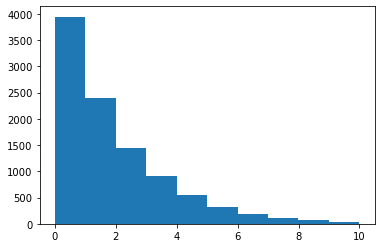

In [36]:
from scipy.stats import expon
import matplotlib.pyplot as plt

dist = expon(0, 2).rvs(size=10000)
dist = dist[dist < 10]
plt.hist(dist)